In [1]:
# Import Required Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.model_selection import train_test_split
import kagglehub

In [2]:
# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
print("Dataset downloaded at:", dataset_path)

# Define paths
IMG_DIR = os.path.join(dataset_path, "Image")
MASK_DIR = os.path.join(dataset_path, "Mask")
IMG_SIZE = 256  # Resize images and masks to 256x256

100%|██████████| 107M/107M [00:00<00:00, 190MB/s] 

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


In [3]:
#Load and Preprocess Data
images, masks = [], []

# Get image and mask file paths
image_paths = sorted(glob.glob(os.path.join(IMG_DIR, '*')))
mask_paths = sorted(glob.glob(os.path.join(MASK_DIR, '*')))

for img_path, mask_path in zip(image_paths, mask_paths):
    # Load image and corresponding mask
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # masks are single-channel

    # Skip corrupted images
    if img is None or mask is None:
        print(f"Skipping: {img_path} or {mask_path}")
        continue

    # Resize and normalize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # make mask shape (H, W, 1)

    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print("Loaded images:", images.shape)
print("Loaded masks :", masks.shape)

Loaded images: (290, 256, 256, 3)
Loaded masks : (290, 256, 256, 1)


In [4]:
# Split into Training and Validation Sets
# Use 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Training set size   :", X_train.shape)
print("Validation set size :", X_val.shape)

Training set size   : (232, 256, 256, 3)
Validation set size : (58, 256, 256, 3)


In [5]:
# Define U-Net Architecture
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Contracting Path
    def encoder_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        skip = x
        x = layers.MaxPooling2D(2)(x)
        return skip, x

    # Decoder: Expanding Path
    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D(2)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    # Build U-Net
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)

    # Bottleneck
    b = layers.Conv2D(128, 3, padding='same', activation='relu')(p3)
    b = layers.Conv2D(128, 3, padding='same', activation='relu')(b)

    # Decoder
    d3 = decoder_block(b, s3, 64)
    d2 = decoder_block(d3, s2, 32)
    d1 = decoder_block(d2, s1, 16)

    # Output layer (1 channel with sigmoid for binary segmentation)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

# Build and compile model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the Model
# Callbacks
checkpoint = ModelCheckpoint("unet_flood_best_model.h5", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5881 - loss: 0.6707
Epoch 1: val_loss improved from inf to 0.57248, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step - accuracy: 0.5882 - loss: 0.6700 - val_accuracy: 0.6660 - val_loss: 0.5725
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7061 - loss: 0.5662
Epoch 2: val_loss improved from 0.57248 to 0.48323, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - accuracy: 0.7068 - loss: 0.5657 - val_accuracy: 0.7918 - val_loss: 0.4832
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7736 - loss: 0.4892
Epoch 3: val_loss improved from 0.48323 to 0.45879, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.7736 - loss: 0.4891 - val_accuracy: 0.7876 - val_loss: 0.4588
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7895 - loss: 0.4320
Epoch 4: val_loss improved from 0.45879 to 0.39976, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.7895 - loss: 0.4321 - val_accuracy: 0.8048 - val_loss: 0.3998
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7943 - loss: 0.4199
Epoch 5: val_loss improved from 0.39976 to 0.38915, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.7938 - loss: 0.4208 - val_accuracy: 0.8294 - val_loss: 0.3891
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8000 - loss: 0.4328
Epoch 6: val_loss did not improve from 0.38915
29/29 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step - accuracy: 0.7999 - loss: 0.4327 - val_accuracy: 0.8163 - val_loss: 0.3922
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8151 - loss: 0.3927
Epoch 7: val_loss improved from 0.38915 to 0.37635, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.8151 - loss: 0.3927 - val_accuracy: 0.8321 - val_loss: 0.3764
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8209 - loss: 0.3855
Epoch 8: val_loss improved from 0.37635 to 0.37461, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.8208 - loss: 0.3857 - val_accuracy: 0.8320 - val_loss: 0.3746
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8262 - loss: 0.3714
Epoch 9: val_loss improved from 0.37461 to 0.35327, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.8264 - loss: 0.3712 - val_accuracy: 0.8410 - val_loss: 0.3533
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8316 - loss: 0.3778
Epoch 10: val_loss did not improve from 0.35327
29/29 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.8314 - loss: 0.3785 - val_accuracy: 0.8453 - val_loss: 0.3604
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8294 - loss: 0.3824
Epoch 11: val_loss did not improve from 0.35327
29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8292 - loss: 0.3828 - val_accuracy: 0.8372 - val_loss: 0.3637
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8274 - loss: 0.3859
Epoch 12: val_loss improved from 0.35327 to 0.31886, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.8274 - loss: 0.3857 - val_accuracy: 0.8518 - val_loss: 0.3189
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8340 - loss: 0.3600
Epoch 13: val_loss did not improve from 0.31886
29/29 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.8339 - loss: 0.3605 - val_accuracy: 0.8162 - val_loss: 0.3775
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8357 - loss: 0.3563
Epoch 14: val_loss did not improve from 0.31886
29/29 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.8359 - loss: 0.3562 - val_accuracy: 0.8421 - val_loss: 0.3617
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8308 - loss: 0.3650
Epoch 15: val_loss improved from 0.31886 to 0.30785, saving model to unet_flood_best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.8311 - loss: 0.3647 - val_accuracy: 0.8568 - val_loss: 0.3078
Epoch 16/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8337 - loss: 0.3617
Epoch 16: val_loss did not improve from 0.30785
29/29 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.8337 - loss: 0.3617 - val_accuracy: 0.8529 - val_loss: 0.3250
Epoch 17/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8330 - loss: 0.3708
Epoch 17: val_loss did not improve from 0.30785
29/29 ━━━━━━━━━━━━━━━━━━━━ 197s 5s/step - accuracy: 0.8325 - loss: 0.3714 - val_accuracy: 0.8412 - val_loss: 0.3392
Epoch 18/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8411 - loss: 0.3552
Epoch 18: val_loss did not improve from 0.30785
29/29 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.8411 - loss: 0.3554 - val_accuracy: 0.8481 - val_loss: 0.3282
Epoch 19/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8355 - loss: 0.3592
Epoch 19: val_loss improved from 0.30785 to 0.29723, sav

29/29 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.8358 - loss: 0.3588 - val_accuracy: 0.8629 - val_loss: 0.2972
Epoch 20/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8376 - loss: 0.3504
Epoch 20: val_loss did not improve from 0.29723
29/29 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.8377 - loss: 0.3505 - val_accuracy: 0.8583 - val_loss: 0.3087
Restoring model weights from the end of the best epoch: 19.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


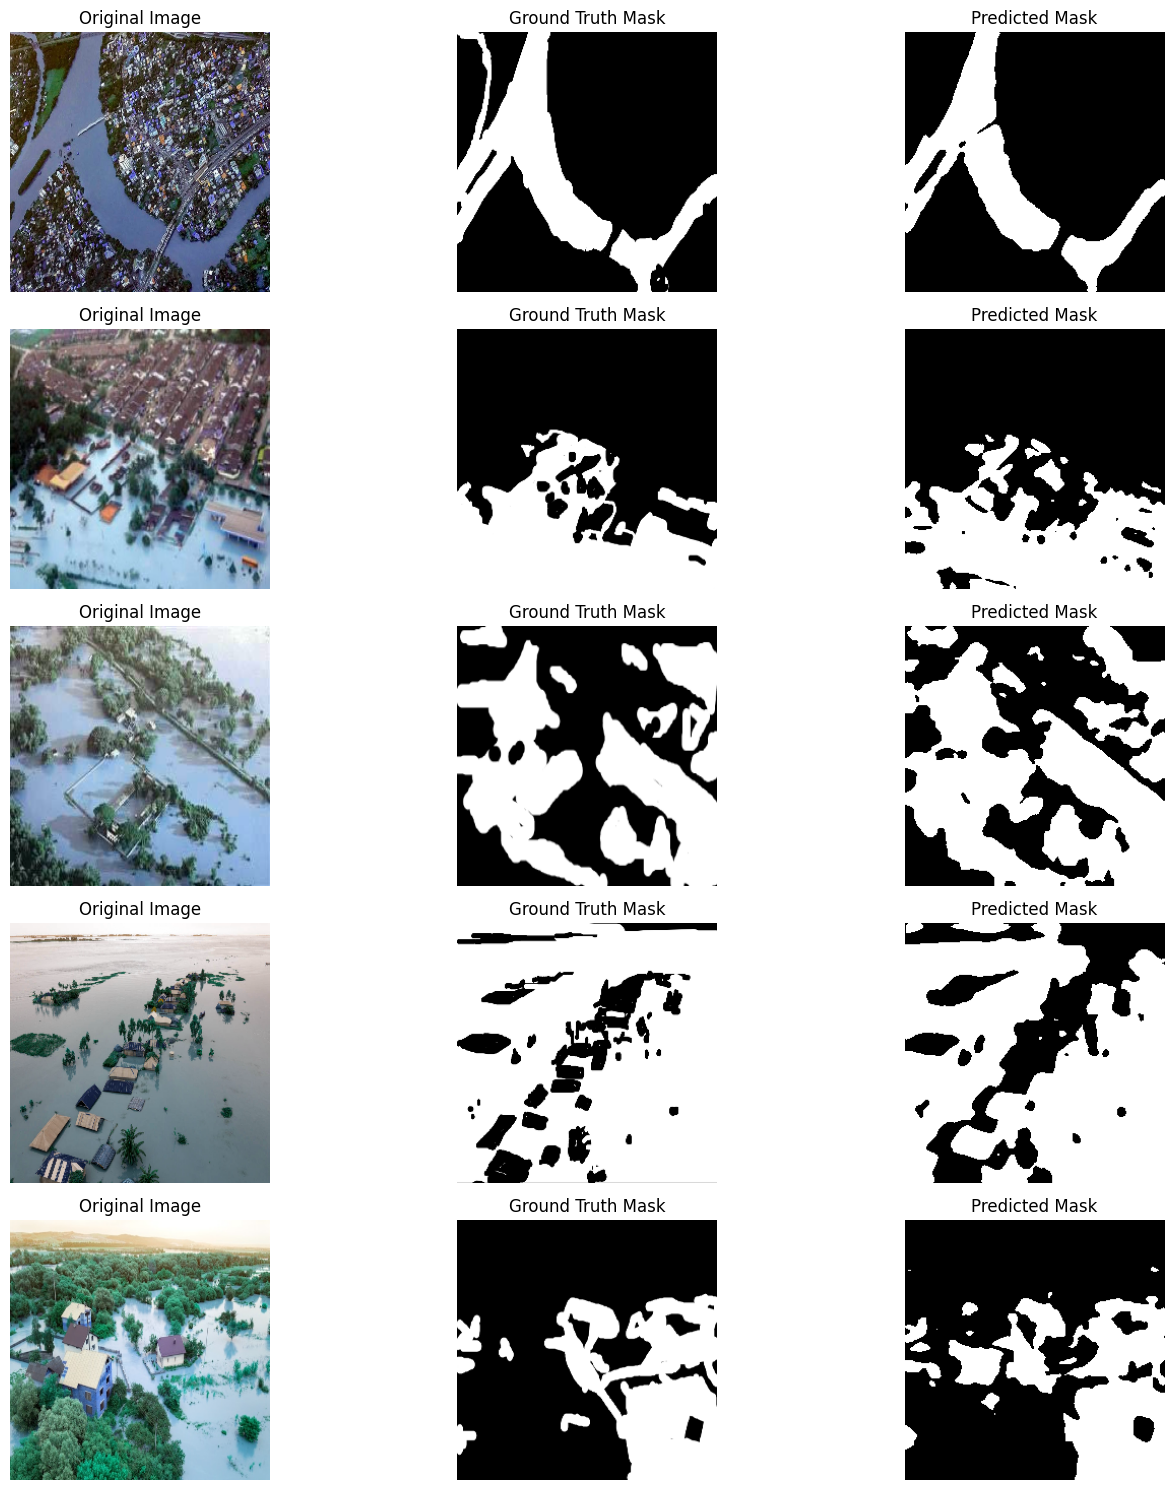

In [7]:
# Visualize Predictions
def visualize_predictions(model, X, y_true, num_samples=5):
    preds = model.predict(X[:num_samples])
    plt.figure(figsize=(15, num_samples * 3))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow((preds[i] > 0.5).squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show predictions
visualize_predictions(model, X_val, y_val, num_samples=5)


In [8]:
# Compute IoU (Intersection over Union)
def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.float32)

    intersection = np.logical_and(y_true, y_pred_bin).sum(axis=(1, 2, 3))
    union = np.logical_or(y_true, y_pred_bin).sum(axis=(1, 2, 3))

    iou = intersection / (union + 1e-7)
    return np.mean(iou)

# Predict masks and compute IoU
y_val_pred = model.predict(X_val, verbose=0)
iou_score = compute_iou(y_val, y_val_pred)
print(f"Mean IoU on validation set: {iou_score:.4f}")

Mean IoU on validation set: 0.7051


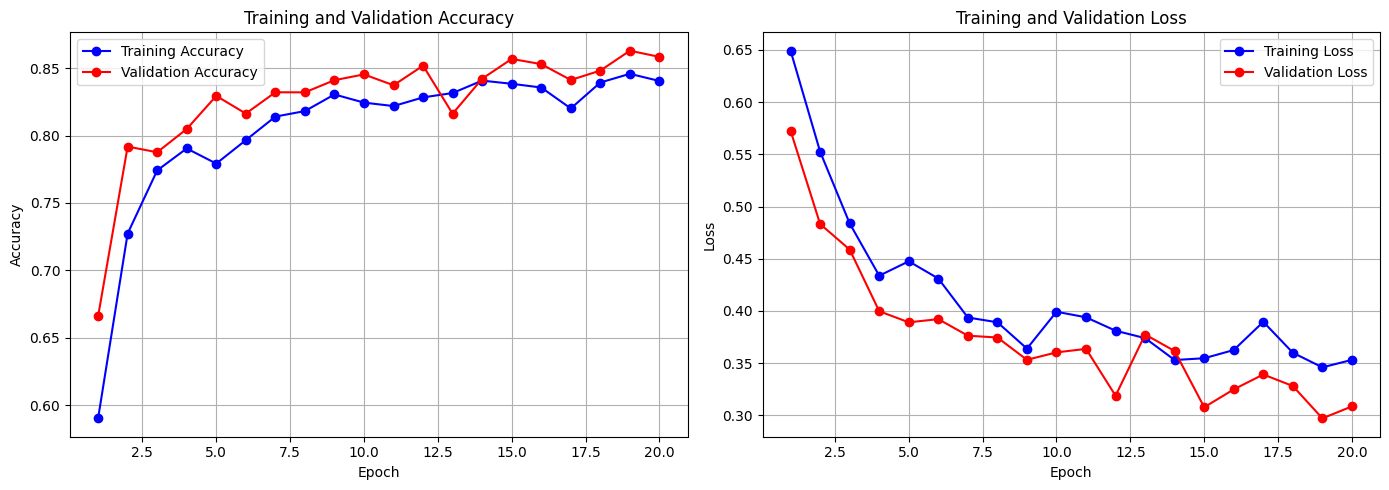

In [9]:
# Plot Loss and Accuracy over Epochs
# Plot training & validation accuracy and loss values
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)